# WARNING
This notebook is the updated version of the `archive/notebooks/report_calculations_and_plots.ipynb` notebook. However, the files in the repo under `results/data` were generated using the archived notebook `archive/notebooks/run_simulations.ipynb` and are not compatible! The code would run and produce animations, but since the geometry is not stored in the .pkl files, the animations would render currents at the wrong positions.

Only use this notebook with data files generated using `notebooks/run_simulations.ipynb` OR use the existing data files with `archive/notebooks/report_calculations_and_plots.ipynb`.

## Data Analysis Notebook
This notebook can be used to obtain the numbers and plots in the report from the .pkl files in the data folder. Data files can be obtained by running the `run_simulations.ipynb` notebook. The repo files were used in the report and obtained with the `archive/notebooks/run_simulations.ipynb` notebook using the lattice module. The report plots were obtained using the `archive/notebooks/report_calculations_and_plots.ipynb` notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import realspace_tb as tb
from realspace_tb import orbitronics_2d as orb

# Spectrum

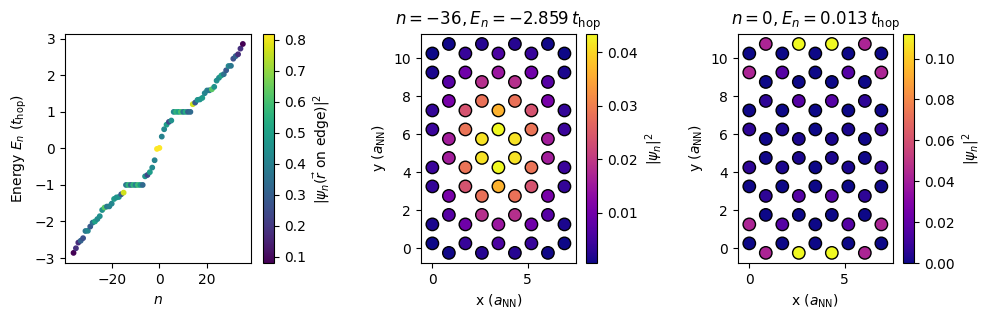

In [14]:
Lx, Ly = 9, 8
geometry = orb.HoneycombLatticeGeometry(Lx, Ly)

H = orb.LinearFieldHamiltonian(
    geometry, orb.RampedACFieldAmplitude(1, 1, 1, np.array([1, 0]))
).at_time(0).toarray()

E, psi = np.linalg.eigh(H)

# Edge indices
indices = np.arange(Lx * Ly)
x = indices % Lx
y = indices // Lx

edge_mask = (x == 0) | (x == Lx - 1) | (y == 0) | (y == Ly - 1)
edge_weight = np.sum(np.abs(psi[edge_mask, :]) ** 2, axis=0)

off = len(E) // 2

# Pick bulk and edge state
bulk_state = 0
edge_state = off

fig, axs = plt.subplots(1, 3, figsize=(10, 3.3), width_ratios=[1.2, 1, 1])

# Spectrum
sc = axs[0].scatter(
    np.arange(-off, off), E, c=edge_weight, cmap="viridis", s=40, marker="."
)
# axs[0].scatter([bulk_state, edge_state], [E[bulk_state], E[edge_state]], c=['b', 'r'], s=50, label="selected")
axs[0].set_xlabel("$n$")
axs[0].set_ylabel("Energy $E_n\\ (t_\\mathrm{hop})$")
# axs[0].set_title("Eigenvalue Spectrum")
# axs[0].grid(True, alpha=0.3)
fig.colorbar(sc, ax=axs[0], label="$|\\psi_n(\\vec r \\text{ on edge})|^2$")

# Positions
positions = np.array([geometry.index_to_position(i) for i in range(Lx * Ly)])
xpos, ypos = positions[:, 0], positions[:, 1]

# Bulk state plot
axs[1].scatter(
    xpos, ypos, c=np.abs(psi[:, bulk_state]) ** 2, cmap="plasma", s=80, edgecolors="k"
)
axs[1].set_title(f"$n={bulk_state-off}, E_n={E[bulk_state]:.3f}\\,t_\\mathrm{{hop}}$")
axs[1].axis("equal")
axs[1].set_xlabel("x $(a_\\mathrm{NN})$")
axs[1].set_ylabel("y $(a_\\mathrm{NN})$")
fig.colorbar(axs[1].collections[0], ax=axs[1], label=r"$|\psi_n|^2$")

# Edge state plot
axs[2].scatter(
    xpos, ypos, c=np.abs(psi[:, edge_state]) ** 2, cmap="plasma", s=80, edgecolors="k"
)
axs[2].set_title(f"$n={edge_state-off}, E_n={E[edge_state]:.3f}\\,t_\\mathrm{{hop}}$")
axs[2].axis("equal")
axs[2].set_xlabel("x $(a_\\mathrm{NN})$")
axs[2].set_ylabel("y $(a_\\mathrm{NN})$")
fig.colorbar(axs[2].collections[0], ax=axs[2], label=r"$|\psi_n|^2$")

plt.tight_layout()
# plt.savefig("spectrum.pdf")
plt.show()

# Animations

In [ ]:
DATA_PATH = "../results/data" # using existing results/data is not compatible with this notebook! See warning at the start of this notebook.
OUT_PATH = ".."

for fn in os.listdir(DATA_PATH):
    if fn.endswith(".pkl"):
        with open(os.path.join(DATA_PATH, fn), "rb") as f:
            d = pickle.load(f)

        if d["substeps"] < 150:
            continue  # only use highest precision data for animations

        omega = d["omega"]
        T = 2 * np.pi / omega

        cycles = 17
        T_ramp = 3 * 2 * np.pi / 0.5

        # Following code matches the time indices since polarization and animation frames where recorded at different time steps.
        # Note that this would be much simpler if the data files were saved using the rewrite realspace_tb version where observables also store the measurement time steps.
        start_index = ((cycles - 1) * T + T_ramp) / (d["h"] / d["substeps"])
        steps = T / (d["h"] / d["substeps"])
        indices = np.arange(start_index, start_index + steps, steps // 20)
        indices = np.astype(indices / (d["substeps"] // 25), int)
        indices = indices[:len(d["animation_values"]["bond_currents"])] # avoid rare off-by-one error

        E_time = d["E_time"]
        E_amplitude = d["E_amplitude"]
        orb_pol_values = d["orb_pol_values"]
        frame_texts = [
            f"$t={E_time[i]:.1f}$ \t $E^{{(y)}}(t)={E_amplitude[i] * 1000 :.2f} \\times 10^{{-3}}$ \t $\\langle P_{{orb}}^{{(x)}}(t)\\rangle={orb_pol_values[i][0] * 1000:.3f} \\times 10^{{-3}}$"
            for i in indices
        ]

        geometry = orb.HoneycombLatticeGeometry(d["Lx"], d["Ly"])

        # Manually create the animation observable and set the values. This is also just a workaround to use the file format from the previous archive/lattice version of the code.
        animation = orb.observables.LatticeFrameObservable(geometry)
        animation.values = {
            "currents": d["animation_values"]["bond_currents"],
            "densities": d["animation_values"]["densities"],
            "plaquette_oam": d["animation_values"]["orbital_curl"],
        }

        orb.save_simulation_animation(
            animation, os.path.join(OUT_PATH, f"{fn[:-4]}.mp4"), frame_texts=frame_texts, fps=3
        )

# OHCs

Absolute values should match the report values (Table 1). Angle values as well but are more sensitve to discrete derivative via forward/backward difference etc.

In [13]:
DATA_PATH = "../results/data"

rows = []
for fname in os.listdir(DATA_PATH):
    path = os.path.join(DATA_PATH, fname)
    if not fname.endswith(".pkl"): continue

    with open(path, "rb") as fh:
        d = pickle.load(fh)

    if d["substeps"] < 150: continue
    if d["Lx"] > 29: continue

    t_eq = 12 * np.pi + 7 * 2 * np.pi / d["omega"]
    t_eq_i = np.searchsorted(d["E_time"], t_eq)
    # find index where time > Trange
    

    P_x = d["orb_pol_values"][:, 0]
    t = d["E_time"]
    orb_current = (np.diff(P_x) / np.diff(t))

    E = d["E_amplitude"][1:]
    dt = t[1] - t[0]

    sigma_orb_xy = orb.ohc(orb_current[t_eq_i:], E[t_eq_i:], dt, d["omega"])

    rows.append({
        "Lx": d.get("Lx"),
        "Ly": d.get("Ly"),
        "omega": d.get("omega"),
        "ohc_abs": float(np.abs(sigma_orb_xy)),
        "ohc_angle": float(np.angle(sigma_orb_xy)),
        #"ohc_Re": float(np.real(sigma_orb_xy)),
        #"ohc_Im": float(np.imag(sigma_orb_xy)),
    })

    dt = np.diff(d["E_time"]).mean()

    # plt.plot(d["E_time"][1:], np.diff(d["orb_pol_values"][:,0]) / dt, label="P")
    # plt.plot(d["E_time"][1:], d["E_amplitude"][1:] * abs(sigma_orb_xy) / (2*np.pi), label="E")
    # plt.legend()
    # plt.show()

ohc_df = pd.DataFrame(rows).sort_values(["omega", "Lx", "Ly"], ignore_index=True)
print(ohc_df.to_string(index=False))

 Lx  Ly  omega  ohc_abs  ohc_angle
 11  20    0.5 0.249228  -2.554343
 11  40    0.5 0.213752  -2.814994
 11  80    0.5 0.215451  -2.931998
 19  20    0.5 0.395793  -2.357227
 19  40    0.5 0.352750  -2.370988
 19  80    0.5 0.348123  -2.442313
 29  20    0.5 0.376693  -2.224081
 29  40    0.5 0.347706  -2.287646
 29  80    0.5 0.341679  -2.338876
 11  20    1.0 0.850397  -2.370391
 11  40    1.0 0.867171  -2.418870
 11  80    1.0 0.852301  -2.420316
 19  20    1.0 0.895708  -2.662828
 19  40    1.0 1.423397  -2.675128
 19  40    1.0 0.858714  -2.729099
 19  80    1.0 0.829063  -2.774576
 29  20    1.0 0.861246  -2.616810
 29  40    1.0 0.778306  -2.667369
 29  80    1.0 0.744470  -2.708348
 11  20    2.0 3.362477   1.604851
 11  40    2.0 3.178010   1.493033
 11  80    2.0 3.101900   1.461692
 19  20    2.0 3.121059   1.666603
 19  40    2.0 3.071493   1.660192
 19  80    2.0 3.047753   1.630908
 29  20    2.0 3.045730   1.791415
 29  40    2.0 2.983399   1.732128
 29  80    2.0 2.972

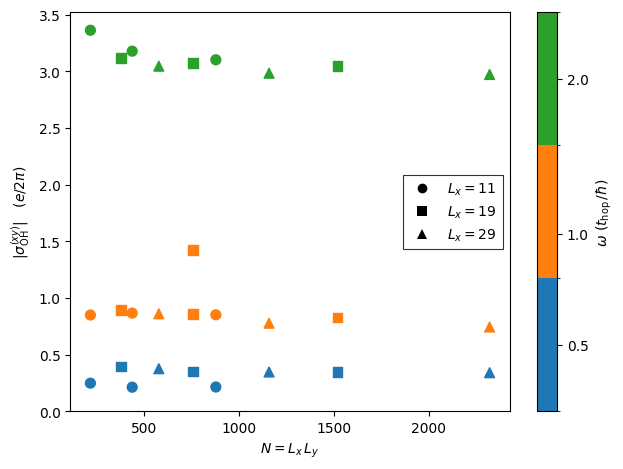

In [14]:
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

omegas = np.sort(ohc_df["omega"].unique())
N = len(omegas)

cmap = plt.get_cmap("tab10", 3*N)
if N == 1:
    bounds = np.array([omegas[0] - 0.1, omegas[0] + 0.1])
else:
    mids = (omegas[:-1] + omegas[1:]) / 2
    first = omegas[0] - (mids[0] - omegas[0])
    last = omegas[-1] + (omegas[-1] - mids[-1])
    bounds = np.concatenate(([first], mids, [last]))
norm = BoundaryNorm(bounds, N)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig = plt.gcf()

cb = fig.colorbar(sm, ax=plt.gca(), ticks=omegas)
cb.ax.set_yticklabels([str(o) for o in omegas])
cb.set_label("$\\omega\\ (t_\\mathrm{hop}\\,/\\hbar)$")

# plot ohc_abs vs system size (Lx*Ly), with markers based on Lx and colors based on omega
markers = ['o', 's', '^']
colors = plt.cm.viridis(np.linspace(0, 1, len(ohc_df["Ly"].unique())))

for i, lx in enumerate(sorted(ohc_df["Lx"].unique())):
    lx_data = ohc_df[ohc_df["Lx"] == lx]
    plt.scatter(
        lx_data["Ly"] * lx_data["Lx"],
        lx_data["ohc_abs"],
        marker=markers[i],
        c=lx_data["omega"],
        s=50,
        label=f'Lx={lx}',
        cmap=cmap,
        norm=norm,
        alpha=1
    )

import matplotlib.lines as mlines

s = mlines.Line2D([], [], color='black', marker='s', ls='', label='$L_x=19$', markeredgewidth=0, markersize=7)
o = mlines.Line2D([], [], color='black', marker='o', ls='', label='$L_x=11$', markeredgewidth=0, markersize=7)
v = mlines.Line2D([], [], color='black', marker='^', ls='', label='$L_x=29$', markeredgewidth=0, markersize=7)

legend = plt.legend(handles=[o,s, v], fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

plt.ylim(bottom=0)
plt.xlabel("$N=L_x\\, L_y$")
plt.ylabel("$|\\sigma_\\mathrm{OH}^{(xy)}| \\quad (e/2\\pi)$")
plt.tight_layout()
#plt.savefig("ohc_vs_size.pdf")
plt.show()

# Errors
are on machine epsilon scale, hence 4th order convergence can not be observed but is expected from previous tests.

In [16]:
DATA_PATH = "../results/data"


rows = []
for fname in os.listdir(DATA_PATH):
    path = os.path.join(DATA_PATH, fname)
    if not fname.endswith(".pkl"): continue

    with open(path, "rb") as fh:
        d = pickle.load(fh)

    if d["Lx"] > 29: continue

    rows.append({
        "Lx": d.get("Lx"),
        "Ly": d.get("Ly"),
        "omega": d.get("omega"),
        "orb_pol_values": d.get("orb_pol_values")[:, 0],
        "substeps": d.get("substeps"),
    })

ohc_df = pd.DataFrame(rows).sort_values(["omega", "Lx", "Ly"], ignore_index=True)

# loop over unique (Lx, Ly, omega) pairs
for (Lx, Ly, omega), group in ohc_df.groupby(["Lx", "Ly", "omega"]):
    # obtain the orp_pol_values for substeos 50, 100, 150
    substeps = group["substeps"].values[0]
    pol_50 = group[group["substeps"] == 50]["orb_pol_values"]
    pol_100 = group[group["substeps"] == 100]["orb_pol_values"]
    pol_200 = group[group["substeps"] == 200]["orb_pol_values"]
    
    #plt.plot(pol_50.values[0], "k-", label="50 substeps", )
    #plt.plot(pol_100.values[0], "r.", label="100 substeps")
    #plt.plot(pol_200.values[0], "b--", label="200 substeps")
    #plt.title(f"Lx={Lx}, Ly={Ly}, omega={omega}")
    #plt.show()

    # calc rms(200-50), rms(200-100)
    rms_50 = np.sqrt(np.mean((pol_200.values[0] - pol_50.values[0])**2))
    rms_100 = np.sqrt(np.mean((pol_200.values[0] - pol_100.values[0])**2))

    print(rms_50, rms_100)

    #print(f"Lx={Lx}, Ly={Ly}, omega={omega}: RMS50/RMS100={rms_100/rms_50:.3e}")

1.732971e-08 1.5455848e-08
2.8957063e-08 2.6172907e-08
4.3059384e-08 3.4203477e-08
2.2630607e-08 2.1058188e-08
2.5228037e-08 2.060285e-08
4.162705e-08 3.2442838e-08
2.19848e-08 1.8979776e-08
2.500946e-08 1.9767583e-08
4.0363147e-08 2.9141908e-08
2.4823628e-08 2.2847999e-08
3.0576278e-08 2.5037513e-08
5.0308753e-08 4.497006e-08
3.543802e-08 3.018892e-08
4.5117147e-05 3.920339e-08
4.829845e-08 3.9324807e-08
3.85071e-08 3.4329528e-08
3.059674e-08 2.5627761e-08
5.3203188e-08 4.3430813e-08
2.6657558e-08 2.2908141e-08
3.1582903e-08 2.6426735e-08
4.8267463e-08 3.9343668e-08
2.746865e-08 2.4179425e-08
2.8723306e-08 2.4478952e-08
4.750069e-08 3.9273875e-08
2.9126287e-08 2.541325e-08
2.8217078e-08 2.3934247e-08
4.665105e-08 3.8626563e-08
